# Fantasy football

## Steps
1. Collect data from files
2. Feature exploration, selection and engineering
3. Fit model to predict points for all the players
4. Use Linear programming to get the best 15 based on constraints

In [419]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import bs4
import requests
import json
import matplotlib.pyplot as plt
import glob
from time import time
import os
from IPython.display import display, Markdown, Latex
import seaborn as sns

# scikit libraries aka holy grail
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer, accuracy_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import Imputer
from sklearn.externals import joblib

%matplotlib inline

## Concatenate historic gameweek data

In [348]:
col_names = ['FirstName', 'Surname', 'PositionsList', 'Team', 'Cost',
       'PointsLastRound', 'TotalPoints', 'YellowCards', 'GoalsConceded',
       'Saves', 'GoalsScored', 'ValueSeason', 'TransfersOutRound', 'PriceFallRound',
       'LastSeasonPoints', 'ValueForm', 'PenaltiesMissed', 'Form',
       'Bonus', 'CleanSheets', 'Assists', 'SelectedByPercent', 'OwnGoals', 
       'PenaltiesSaved', 'DreamteamCount', 'MinutesPlayed', 'TransfersInRound',
       'PriceRiseRound', 'RedCards', 'BPS','NextFixture2']
# 'NextFixture1', 'NextFixture2', 'NextFixture3', 'NextFixture4', 'NextFixture5' - use difficulty of teams
# as feature

In [349]:
features = ['PositionsList','Cost','TransfersOutRound','PriceFallRound',
           'LastSeasonPoints', 'ValueForm','Form','Bonus','SelectedByPercent','TransfersInRound',
       'PriceRiseRound']
# add team as feature and try to model

In [350]:
cumulative_measures = ['YellowCards', 'GoalsConceded',
                       'Saves', 'GoalsScored', 'PenaltiesMissed', 
                       'CleanSheets', 'Assists', 'OwnGoals' ,
                       'PenaltiesSaved', 'DreamteamCount', 'MinutesPlayed',
                       'RedCards', 'BPS']

In [351]:
all_files = glob.glob(os.path.join('./data/historic_data/', '*.csv'))
# df = pd.concat(map(pd.read_csv(usecols=col_names), )))

In [352]:
def read_data(filename):
    dataframe = pd.read_csv(filename, usecols=col_names)
    file_year_gw = filename.split('FPL')[1]
    
    fpl_year = '20' + file_year_gw[0:2]
    fpl_gw = file_year_gw.split('GW')[1].split('.csv')[0]
    fpl_gw = ('0' + fpl_gw) if len(fpl_gw) == 1 else fpl_gw
    
    dataframe['Cost'] = dataframe['Cost']/1e6 #Convert cost to millions unit
    dataframe['PlayerName'] = dataframe['FirstName'].fillna('') + ' ' + dataframe['Surname'].fillna('') # combine first and last name
    dataframe['Year'] = int(fpl_year)
    dataframe['Gameweek'] = int(fpl_gw)
    dataframe.drop(['FirstName','Surname'], axis = 1, inplace = True)
    cols = list(dataframe.columns)
    cols = cols[-3:] + cols[:-3] # reorder columns
    return dataframe[cols]

In [353]:
df = pd.concat(map(read_data, all_files)).reset_index(drop = True)
df.sort_values(['PlayerName','Year','Gameweek'], inplace=True)
df['PointsLastRound'] = pd.to_numeric(df.PointsLastRound, errors='coerce').fillna(0)
df = df[df.Gameweek != 0].reset_index(drop=True) # remove cumulative game week files (gameweek 0)
df.head()

,PlayerName,Year,Gameweek,PositionsList,Team,Cost,PointsLastRound,TotalPoints,YellowCards,GoalsConceded,...,SelectedByPercent,OwnGoals,PenaltiesSaved,DreamteamCount,MinutesPlayed,TransfersInRound,PriceRiseRound,RedCards,BPS,NextFixture2
0,Adam Smith,2017,1,DEF,BOU,5.0,1.0,1,0,0,...,1.1,0,0,0,10,403,0,0,2,Man City
1,Adam Smith,2017,2,DEF,BOU,5.0,1.0,2,0,2,...,0.9,0,0,0,100,133,0,0,16,Arsenal
2,Adam Smith,2017,3,DEF,BOU,4.9,0.0,2,1,4,...,0.8,0,0,0,190,332,-1,0,26,Brighton
3,Adam Smith,2017,4,DEF,BOU,4.9,1.0,3,1,7,...,0.7,0,0,0,280,384,0,0,36,Everton
4,Adam Smith,2017,5,DEF,BOU,4.9,2.0,5,1,8,...,0.6,0,0,0,370,140,0,0,53,Leicester


In [354]:
# players who have played less than 400 minutes throught the season
df_lesstime = (df.groupby(['PlayerName','Year'])['PointsLastRound','MinutesPlayed']
                 .agg({'PointsLastRound':'sum', 'MinutesPlayed':'max'})[['MinutesPlayed']]
                 .transform(lambda x: x < 400)
                 .query('MinutesPlayed == True')
                 .reset_index()
              )
df_lesstime.head()

,PlayerName,Year,MinutesPlayed
0,Angelino,2016,True
1,Baba Rahman,2016,True
2,Bojan,2017,True
3,Brad Smith,2017,True
4,Costa,2017,True


In [355]:
df_lesstime.PlayerName.unique()

array([' Angelino', ' Baba Rahman', ' Bojan', ' Brad Smith', ' Costa',
       ' Eduardo', ' Emerson', ' Ethan Robson', ' Fernando', ' Gabriel',
       ' Gamez', ' Garcia', ' J Pereira', ' Joe Williams', ' Joel Pereira',
       ' Jonathan Benteke', ' Joselu', ' Josh Robson', ' Kenedy',
       ' Kevin Long', ' Ki Sung+AC0-yueng', ' Lee Chung+AC0-yong',
       ' Lee Chung-yong', ' Lucas Moura', ' Marc Wilson', ' Martinez',
       ' Mika', ' Nolito', ' Nsue', ' Pau Lopez', ' Sandro', ' Sheyi Ojo',
       ' Thomas Robson', ' Tosin Adarabioyo', ' Yaya Toure',
       'Aaron Ramsdale', 'Aaron Wan-Bissaka', 'Abdelhamid Sabiri',
       'Adam Federici', 'Adam Lallana', 'Adam Legzdins', 'Adam Matthews',
       'Adam Reach', 'Ademola Lookman', 'Ahmed Musa', "Aiden O'Neill",
       'Ainsley Maitland-Niles', 'Albert Adomah', 'Alberto Moreno',
       'Aleksandar Kolarov', 'Aleksandar Mitrovic', 'Alex Baptiste',
       'Alex Bruce', 'Alex McCarthy', 'Alex Palmer', 'Alex Pike',
       'Alex Pritchard', 

In [356]:
# remove players for seasons where they have played less than 400 minutes
df_filt = df[~((df.PlayerName.isin(df_lesstime.PlayerName))&(df.Year.isin(df_lesstime.Year)))]

In [357]:
df_filt.head()

,PlayerName,Year,Gameweek,PositionsList,Team,Cost,PointsLastRound,TotalPoints,YellowCards,GoalsConceded,...,SelectedByPercent,OwnGoals,PenaltiesSaved,DreamteamCount,MinutesPlayed,TransfersInRound,PriceRiseRound,RedCards,BPS,NextFixture2
0,Adam Smith,2017,1,DEF,BOU,5.0,1.0,1,0,0,...,1.1,0,0,0,10,403,0,0,2,Man City
1,Adam Smith,2017,2,DEF,BOU,5.0,1.0,2,0,2,...,0.9,0,0,0,100,133,0,0,16,Arsenal
2,Adam Smith,2017,3,DEF,BOU,4.9,0.0,2,1,4,...,0.8,0,0,0,190,332,-1,0,26,Brighton
3,Adam Smith,2017,4,DEF,BOU,4.9,1.0,3,1,7,...,0.7,0,0,0,280,384,0,0,36,Everton
4,Adam Smith,2017,5,DEF,BOU,4.9,2.0,5,1,8,...,0.6,0,0,0,370,140,0,0,53,Leicester


> **Output columns:** Points Last Round/ Total points

## Explore data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdb9719ca90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fdbb8db1da0>]], dtype=object)

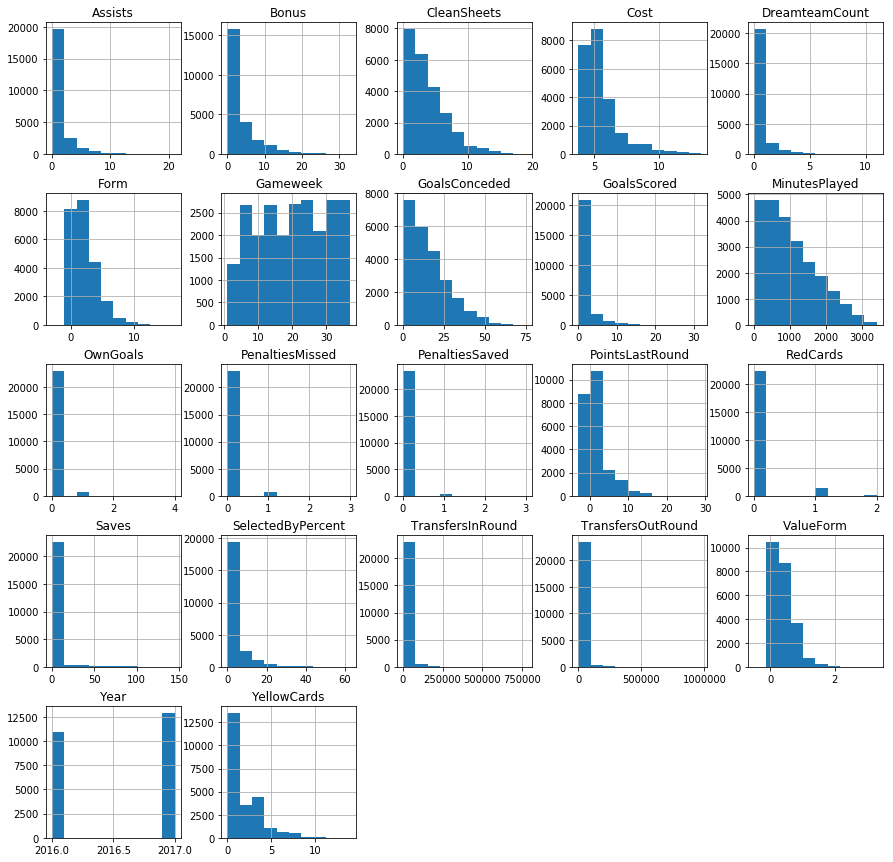

In [358]:
df_filt.hist(figsize = (15,15))

In [359]:
df_filt.dtypes

PlayerName            object
Year                   int64
Gameweek               int64
PositionsList         object
Team                  object
Cost                 float64
PointsLastRound      float64
TotalPoints           object
YellowCards            int64
GoalsConceded          int64
Saves                  int64
GoalsScored            int64
ValueSeason           object
TransfersOutRound      int64
PriceFallRound        object
LastSeasonPoints      object
ValueForm            float64
PenaltiesMissed        int64
Form                 float64
Bonus                  int64
CleanSheets            int64
Assists                int64
SelectedByPercent    float64
OwnGoals               int64
PenaltiesSaved         int64
DreamteamCount         int64
MinutesPlayed          int64
TransfersInRound       int64
PriceRiseRound        object
RedCards               int64
BPS                   object
NextFixture2          object
dtype: object

> There are a lot of fields with 0. This could be because people a) A lot of players hardly play or b) Lot of fields not have have a good spread of values

## Feature engineering

In [360]:
top_6 = ['Arsenal','Chelsea','Man Utd','Man City','Liverpool','Tottenham']

In [241]:
df_filt.columns

Index(['PlayerName', 'Year', 'Gameweek', 'PositionsList', 'Team', 'Cost',
       'PointsLastRound', 'TotalPoints', 'YellowCards', 'GoalsConceded',
       'Saves', 'GoalsScored', 'ValueSeason', 'TransfersOutRound',
       'PriceFallRound', 'LastSeasonPoints', 'ValueForm', 'PenaltiesMissed',
       'Form', 'Bonus', 'CleanSheets', 'Assists', 'SelectedByPercent',
       'OwnGoals', 'PenaltiesSaved', 'DreamteamCount', 'MinutesPlayed',
       'TransfersInRound', 'PriceRiseRound', 'RedCards', 'BPS'],
      dtype='object')

In [366]:
t0 = time()
final_df = list()
for i,j in df_filt.groupby(['PlayerName','Year']):
    df_player = pd.DataFrame(j[cumulative_measures].apply(pd.to_numeric, errors='coerce'))
    df_player = df_player.diff().fillna(df_player.iloc[0])
    df_player['PlayerName'] = i[0].strip()
    df_player['Gameweek'] = j['Gameweek']
    df_player['Year'] = i[1]
    df_player['PointsGameweek'] = j['PointsLastRound']
    df_player['TopSixOpposition'] = np.where((j['NextFixture2'].isin(top_6)), True, False)
    df_player[features] = j[features]
    PointsNextFixture1 = df_player[['PointsGameweek']].shift(-1).fillna(0)
    PointsNextFixture2 = df_player[['PointsGameweek']].shift(-2).fillna(0)
    PointsNextFixture3 = df_player[['PointsGameweek']].shift(-3).fillna(0)
    df_player['PointsNextWeek1'] = PointsNextFixture1
    df_player['PointsNextWeek1_classify'] = PointsNextFixture1 >= 4 # for classification problem
    
    # Compute cumulative points for the next 3 gameweeks
    df_player['CumuPoints3Weeks'] = (PointsNextFixture1 +
                                     PointsNextFixture2 +
                                     PointsNextFixture3)
    # Compute weighted average of points for next 3 gameweeks(Weights by week: 0.5, 0.3 and 0.2)
    df_player['WeightAvgPoints3Weeks'] = (PointsNextFixture1 * 0.5 +
                                         PointsNextFixture2 * 0.3 +
                                         PointsNextFixture3 * 0.2 )
    
    cols = list(df_player.columns)
    rearrange_no = len(cols) - len(cumulative_measures)
    cols = cols[-rearrange_no:] + cols[:-rearrange_no] # reorder columns
    final_df.append(df_player[cols])
final_df = pd.concat(final_df, axis=0)
print('Time taken {:.3f}'.format(time()-t0))

Time taken 48.588


In [367]:
final_df.head()

,PlayerName,Gameweek,Year,PointsGameweek,TopSixOpposition,PositionsList,Cost,TransfersOutRound,PriceFallRound,LastSeasonPoints,...,GoalsScored,PenaltiesMissed,CleanSheets,Assists,OwnGoals,PenaltiesSaved,DreamteamCount,MinutesPlayed,RedCards,BPS
0,Adam Smith,1,2017,1.0,True,DEF,5.0,5129,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,2.0
1,Adam Smith,2,2017,1.0,True,DEF,5.0,6713,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,14.0
2,Adam Smith,3,2017,0.0,False,DEF,4.9,4907,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,10.0
3,Adam Smith,4,2017,1.0,False,DEF,4.9,2732,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,10.0
4,Adam Smith,5,2017,2.0,False,DEF,4.9,3172,0,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,17.0


Text(0.5,1,'Pairwise correlation')

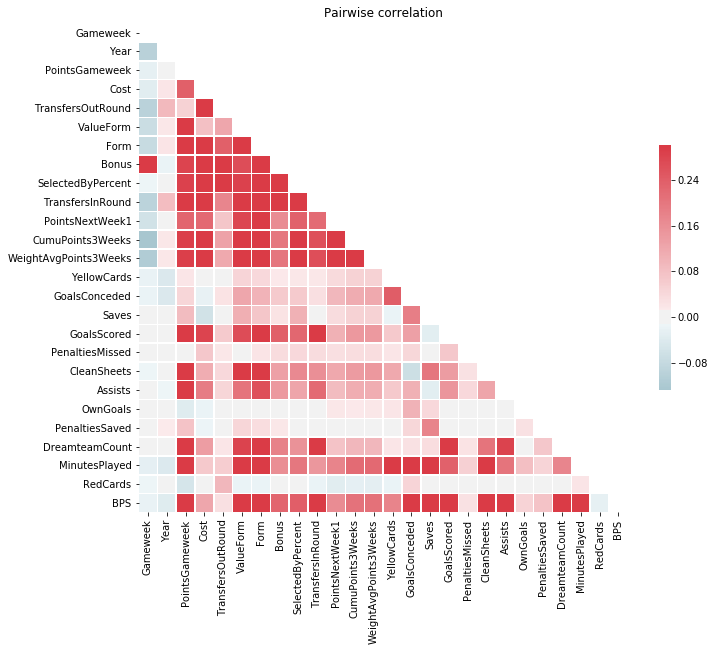

In [368]:
# source for code: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
d = final_df.loc[:,[cols for cols in final_df.columns if final_df[cols].dtype in [float,int]]]
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title('Pairwise correlation')

In [369]:
output_cols = ['PointsNextWeek1', 'CumuPoints3Weeks', 'WeightAvgPoints3Weeks','PointsNextWeek1_classify']

In [370]:
display(Markdown('**Average points of players for Gameweeks they made it to the Dream Team, the points they scored in the next week and the Weighted average of points for the next 3 weeks**'))
(final_df[(final_df.DreamteamCount == 1) & (final_df.Gameweek <= 35)]
.groupby(['Gameweek','Year'])
.agg('mean')[['PointsGameweek','PointsNextWeek1','WeightAvgPoints3Weeks','PointsNextWeek1_classify']]
.mean())

**Average points of players for Gameweeks they made it to the Dream Team, the points they scored in the next week and the Weighted average of points for the next 3 weeks**

PointsGameweek              12.043762
PointsNextWeek1              3.337036
WeightAvgPoints3Weeks        3.276452
PointsNextWeek1_classify     0.317691
dtype: float64

In [371]:
final_df = pd.concat([final_df.drop('PositionsList', axis=1), 
                          pd.get_dummies(final_df['PositionsList'])],
                     axis=1).reset_index(drop = True)

In [372]:
final_df.columns

Index(['PlayerName', 'Gameweek', 'Year', 'PointsGameweek', 'TopSixOpposition',
       'Cost', 'TransfersOutRound', 'PriceFallRound', 'LastSeasonPoints',
       'ValueForm', 'Form', 'Bonus', 'SelectedByPercent', 'TransfersInRound',
       'PriceRiseRound', 'PointsNextWeek1', 'PointsNextWeek1_classify',
       'CumuPoints3Weeks', 'WeightAvgPoints3Weeks', 'YellowCards',
       'GoalsConceded', 'Saves', 'GoalsScored', 'PenaltiesMissed',
       'CleanSheets', 'Assists', 'OwnGoals', 'PenaltiesSaved',
       'DreamteamCount', 'MinutesPlayed', 'RedCards', 'BPS', 'DEF', 'FWD',
       'GLK', 'MID'],
      dtype='object')

In [373]:
final_df[['Gameweek','Year']] = final_df[['Gameweek','Year']].applymap(str)

In [374]:
final_df.head()

,PlayerName,Gameweek,Year,PointsGameweek,TopSixOpposition,Cost,TransfersOutRound,PriceFallRound,LastSeasonPoints,ValueForm,...,OwnGoals,PenaltiesSaved,DreamteamCount,MinutesPlayed,RedCards,BPS,DEF,FWD,GLK,MID
0,Adam Smith,1,2017,1.0,True,5.0,5129,0,1,0.2,...,0.0,0.0,0.0,10.0,0.0,2.0,1,0,0,0
1,Adam Smith,2,2017,1.0,True,5.0,6713,0,2,0.2,...,0.0,0.0,0.0,90.0,0.0,14.0,1,0,0,0
2,Adam Smith,3,2017,0.0,False,4.9,4907,1,2,0.1,...,0.0,0.0,0.0,90.0,0.0,10.0,1,0,0,0
3,Adam Smith,4,2017,1.0,False,4.9,2732,0,3,0.1,...,0.0,0.0,0.0,90.0,0.0,10.0,1,0,0,0
4,Adam Smith,5,2017,2.0,False,4.9,3172,0,5,0.2,...,0.0,0.0,0.0,90.0,0.0,17.0,1,0,0,0


In [375]:
final_df['PointsNextWeek1_classify'].value_counts()

False    19663
True      4178
Name: PointsNextWeek1_classify, dtype: int64

In [376]:
print('Ratio of players with more than 4 points in the next week to ones less than 4 points is {:.3f}'.format(4178/19663))

Ratio of players with more than 4 points in the next week to ones less than 4 points is 0.212


Might have to balance the dataset before prediction. There is a 1:5 ratio between the 2 classes (Points >= 4 and points <= 4)

In [377]:
final_df.to_csv('./data/Processed_data.csv')

## Train-test split

In [378]:
final_df.dtypes

PlayerName                   object
Gameweek                     object
Year                         object
PointsGameweek              float64
TopSixOpposition               bool
Cost                        float64
TransfersOutRound             int64
PriceFallRound               object
LastSeasonPoints             object
ValueForm                   float64
Form                        float64
Bonus                         int64
SelectedByPercent           float64
TransfersInRound              int64
PriceRiseRound               object
PointsNextWeek1             float64
PointsNextWeek1_classify       bool
CumuPoints3Weeks            float64
WeightAvgPoints3Weeks       float64
YellowCards                 float64
GoalsConceded               float64
Saves                       float64
GoalsScored                 float64
PenaltiesMissed             float64
CleanSheets                 float64
Assists                     float64
OwnGoals                    float64
PenaltiesSaved              

In [379]:
model_feats = [col for col in final_df.columns if col not in output_cols and final_df[col].dtype != object]
model_feats

['PointsGameweek',
 'TopSixOpposition',
 'Cost',
 'TransfersOutRound',
 'ValueForm',
 'Form',
 'Bonus',
 'SelectedByPercent',
 'TransfersInRound',
 'YellowCards',
 'GoalsConceded',
 'Saves',
 'GoalsScored',
 'PenaltiesMissed',
 'CleanSheets',
 'Assists',
 'OwnGoals',
 'PenaltiesSaved',
 'DreamteamCount',
 'MinutesPlayed',
 'RedCards',
 'BPS',
 'DEF',
 'FWD',
 'GLK',
 'MID']

In [380]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(final_df.loc[:,model_feats],
                                                    final_df.loc[:,output_cols], 
                                                    test_size=0.30, random_state=123)

In [381]:
X_train_valid.columns

Index(['PointsGameweek', 'TopSixOpposition', 'Cost', 'TransfersOutRound',
       'ValueForm', 'Form', 'Bonus', 'SelectedByPercent', 'TransfersInRound',
       'YellowCards', 'GoalsConceded', 'Saves', 'GoalsScored',
       'PenaltiesMissed', 'CleanSheets', 'Assists', 'OwnGoals',
       'PenaltiesSaved', 'DreamteamCount', 'MinutesPlayed', 'RedCards', 'BPS',
       'DEF', 'FWD', 'GLK', 'MID'],
      dtype='object')

In [382]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid,
                                                    y_train_valid,
                                                    test_size=0.20, random_state=123)

In [383]:
X_train.shape

(13350, 26)

In [384]:
y_train.columns

Index(['PointsNextWeek1', 'CumuPoints3Weeks', 'WeightAvgPoints3Weeks',
       'PointsNextWeek1_classify'],
      dtype='object')

## Feature importance

Two ways to go about prediction --
1. Classic regression task where you try and predict points and find root mean square difference to compare and evaluate performance of models
2. Make it a classification task where you predict if player is likely to score more than 4 points in a gameweek. Why 4? Because that is the number of points you lose while you make more than one transfer per week. 

In [420]:
param_grid = {'n_estimators': [100,500]}
clf = GridSearchCV(RandomForestClassifier(verbose=0, n_jobs=4, class_weight='balanced'), param_grid, cv=7, error_score=make_scorer(recall_score))
clf.fit(X_train_valid.values, y_train_valid['PointsNextWeek1_classify'].values)

GridSearchCV(cv=7, error_score=make_scorer(recall_score),
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 500]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [421]:
clf.best_score_

0.8231663470757431

In [422]:
X_train_valid.columns

Index(['PointsGameweek', 'TopSixOpposition', 'Cost', 'TransfersOutRound',
       'ValueForm', 'Form', 'Bonus', 'SelectedByPercent', 'TransfersInRound',
       'YellowCards', 'GoalsConceded', 'Saves', 'GoalsScored',
       'PenaltiesMissed', 'CleanSheets', 'Assists', 'OwnGoals',
       'PenaltiesSaved', 'DreamteamCount', 'MinutesPlayed', 'RedCards', 'BPS',
       'DEF', 'FWD', 'GLK', 'MID'],
      dtype='object')

In [423]:
feat_imp = list(zip(list(X_train_valid.columns), clf.best_estimator_.feature_importances_))

In [424]:
pd.DataFrame(feat_imp, columns=['Features','Importance']).sort_values('Importance',ascending = False).reset_index(drop=True)

,Features,Importance
0,TransfersInRound,0.178499
1,TransfersOutRound,0.129620
2,SelectedByPercent,0.099294
3,Cost,0.097379
4,Form,0.096594
5,BPS,0.074429
6,ValueForm,0.061632
7,Bonus,0.058582
8,MinutesPlayed,0.053632
9,PointsGameweek,0.035119
